# Batting Stats in the 2017 Playoffs

### MSP 10.16.2017



In [1]:
from IPython.display import HTML
HTML('''<script>code_show=true; function code_toggle() { if (code_show){ $('div.input').hide();} else { $('div.input').show(); } code_show = !code_show} $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import matplotlib as mpl



In [2]:
# imports for scraping

from bs4 import BeautifulSoup
import requests


# basic birth year reader. tables[1] has good stuff in it!
def get_birth_year(tables):

    birthdate_start = (tables[1].text).find("Birthdate:")

    birthdate_end =  (tables[1].text).find('(',birthdate_start)

    #print (tables[1].text)[birthdate_start:birthdate_end]
    birth_year = (tables[1].text)[birthdate_start:birthdate_end].split('/')[2]
    #print birth_year
    
    return birth_year





In [3]:
# the listing of the teams of interest (all!)

teams = ['astros','cubs','dodgers','yankees']

# verify we got all the teams...
print len(teams)

4


#### Compile Hitters

This cell only needs to be run in the event that player ID numbers change, or new players are added.

In [6]:
#
# make hitter dictionary
#
HDict = {}


for team in teams:
    
    print team,
    
    get_url = 'http://www.fangraphs.com/teams/'+team#angels'

    r  = requests.get(get_url)

    data = r.text

    soup = BeautifulSoup(data)

    tables = soup.findAll('table')


    for row in tables[5].find_all("tr")[1:]: 
    
        sav = [td.find('a') for td in row.find_all("td")][0]
    
        try:
            need_url = sav.get('href')
            
            sav2 = [td.get_text() for td in row.find_all("td")]
        
            # Apply a PA cut?
            if float(sav2[3]) > 0.:
                HDict[sav.text] = need_url[(need_url).find('playerid')+9:(need_url).find('&')]
        
        except:
            pass
    
f = open('data/batterdict_postseason.dat','w')

for entry in HDict.keys():
    try:
        print >>f,entry,'|',HDict[entry]
    except:
        print entry,'|',HDict[entry]
    

f.close()

astros cubs dodgers yankees


In [7]:

HDict = {}

f = open('data/batterdict_postseason.dat')

for line in f:
    #print line
    try:
        HDict[(line.split('|')[0]).strip()] = line.split('|')[1]
    except:
        pass
    
    
print('Found {} hitters by scraping teams.'.format(len(HDict.keys())))

Found 142 hitters by scraping teams.


### Grab the Stats

In [10]:
#
# for an individual player
#'

itable = [u'Season', u'Team', u'G', u'AB', u'PA', u'H', u'1B', \
          u'2B', u'3B', u'HR', u'R', u'RBI', u'BB', u'IBB',\
          u'SO', u'HBP', u'SF', u'SH', u'GDP', u'SB', u'CS', u'AVG']
#             0         1        2    3     4      5     6  \
#            7      8   9       10    11      12     13  \
#            14    15    16    17      18       19      20     21


# these are categories to eliminate
projections = ['Depth Charts','Fans',\
               'Fans (6)','Fans (7)','Fans (11)','Fans (12)','Fans (14)','Fans (15)',\
               'Steamer',\
               'ZiPS', 'ZiPS (R)','Steamer (R)','Depth Charts (R)','Average','Postseason']

minors = ['(AA)','(A)','(AAA)','(R)','(A+)','(A-)']

agg = ['Total']



plist = ['Joey Votto','Albert Pujols','Mike Trout']


#for player in HDict.keys():

def obtain_players_postseason(plist,year='2017'):
    
    # set up dictionary
    PVals = {}

    pnum = 0

    for player in plist:
        
        #print player,

        get_url = 'http://www.fangraphs.com/statss.aspx?playerid='+str(HDict[player].strip())

        r  = requests.get(get_url)

        data = r.text

        soup = BeautifulSoup(data)

        tables = soup.findAll('table')


        for indx,table in enumerate(tables):

            #print indx,[th.get_text() for th in table.find("tr").find_all("th")]

            if [th.get_text() for th in table.find("tr").find_all("th")] == itable:

                #print get_url
                print pnum,player

                pnum += 1

                #print [th.get_text() for th in table.find("tr").find_all("th")]

                #print table.find_all("tr", class_="grid_multi")

                for row in table.find_all("tr")[1:]:

                    if (row in table.find_all("tr", class_="grid_multi")):
                            #print 'Multi and/or Postseason:',sav[0]
                            continue

                    if (row not in table.find_all("tr", class_="grid_postseason")):
                            #print 'Multi and/or Postseason:',sav[0]
                            continue



                    sav = [td.get_text() for td in row.find_all("td")]

                    if (np.sum([(x.strip() in sav[1]) for x in projections])==0) & \
                    (np.sum([(x in sav[1]) for x in minors])==0) & \
                    (np.sum([(x in sav[0]) for x in agg])==0) &\
                    (sav[0] == year): 
                        try:
                            #print sav[0]
                            float(sav[-1])
                            float(sav[0])

                            #print sav[0],sav[1],float(sav[4])>50.

                            # current problem is that postseason is mixed in

                            if (float(sav[4])>00.):
                                # sav[4] is PA
                                PVals[player] = {}
                                PVals[player]['1B'] = float(sav[6])
                                PVals[player]['2B'] = float(sav[7])
                                PVals[player]['3B'] = float(sav[8])
                                PVals[player]['HR'] = float(sav[9])
                                PVals[player]['R']  = float(sav[10])
                                PVals[player]['RBI'] = float(sav[11])
                                PVals[player]['AB'] = float(sav[3])
                                PVals[player]['SB'] = float(sav[19])
                                PVals[player]['SO'] = float(sav[14])

                            #if (float(sav[7])<50.):
                            #    print 'rejected for too few innings:',sav[0],float(sav[7])

                        except:
                            # this is janky way to skip postseason. please fix this
                            #print 'Skipped for postseason',sav[0],sav[1]
                            pass

    return PVals


PValsFull = obtain_players_postseason(HDict.keys())



0 Garrett Cooper
1 Juan Centeno
2 Adrian Gonzalez
3 O'Koyea Dickson
4 Max Stassi
5 Gary Sanchez
6 Evan Gattis
7 Javier Baez
8 Starlin Castro
9 Kyle Schwarber
10 Yasiel Puig
11 Josh Reddick
12 Tony Kemp
13 Derek Fisher
14 Mark Zagunis
15 Ronald Torreyes
16 Corey Seager
17 Jake Marisnick
18 Gregory Bird
19 Miguel Montero
20 Leonys Martin
21 Pete Kozma
22 Andre Ethier
23 Tyler Austin
24 Erik Kratz
25 A.J. Reed
26 Ji-Man Choi
27 Jeimer Candelario
28 Colin Moran
29 Austin Romine
30 Franklin Gutierrez
31 Aaron Hicks
32 J.D. Davis
33 Kyle Farmer
34 Miguel Andujar
35 Carlos Correa
36 Alex Avila
37 Kike Hernandez
38 Mike Freeman
39 Chase Utley
40 Ben Zobrist
41 Jacoby Ellsbury
42 Charlie Culberson
43 Nori Aoki
44 Chris Carter
45 Yulieski Gurriel
46 Matt Szczur
47 Curtis Granderson
48 Yasmani Grandal
49 Scott Van Slyke
50 Brian McCann
51 Trayce Thompson
52 Jose Altuve
53 Marwin Gonzalez
54 Logan Forsythe
55 Victor Caratini
56 Chase Headley
57 Cameron Maybin
58 Jon Jay
59 Cody Bellinger
60 Rob Re

### Visualize the Data

Bar Chart time!

{'AB': 27.0, '2B': 2.0, 'HR': 0.0, 'R': 3.0, 'SO': 7.0, 'RBI': 2.0, 'SB': 0.0, '1B': 3.0, '3B': 0.0}


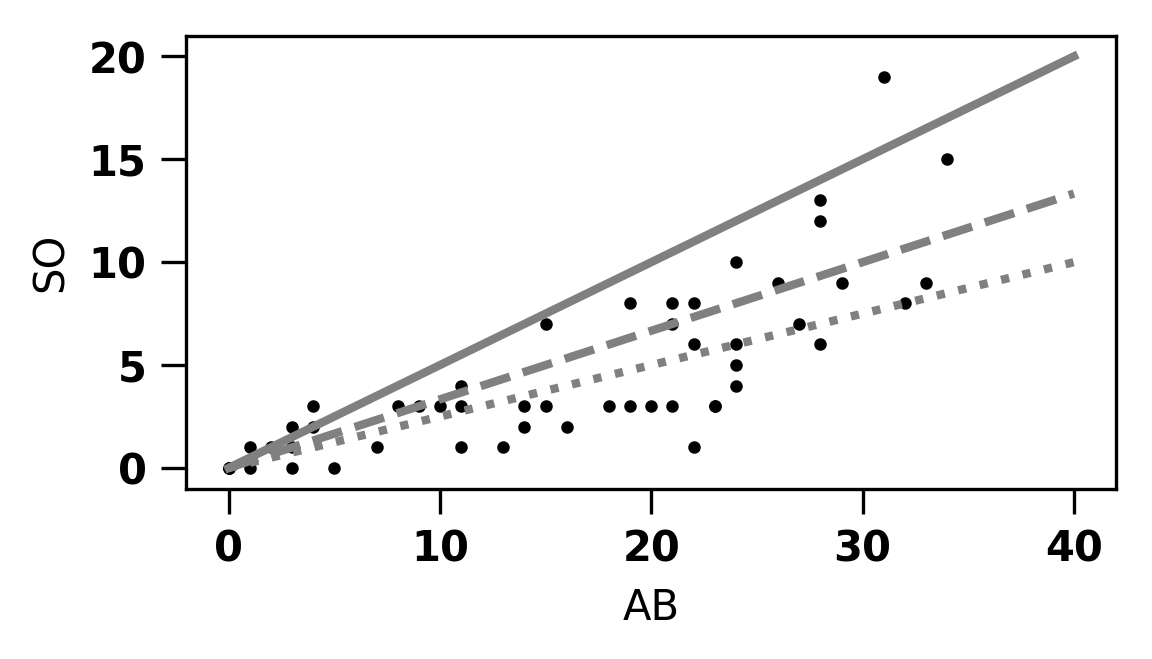

In [20]:

SO = np.zeros(len(PValsFull.keys()))
AB = np.zeros(len(PValsFull.keys()))



for indx,player in enumerate(np.array(PValsFull.keys())):
    SO[indx] = PValsFull[player]['SO']
    AB[indx] = PValsFull[player]['AB']



print PValsFull['Todd Frazier']

plt.figure(figsize=(4,2))
plt.scatter(AB,SO,color='black',s=4.)
plt.plot([0.,40.],[0.,20.],color='gray')
plt.plot([0.,40.],[0.,40./3.],color='gray',linestyle='dashed')
plt.plot([0.,40.],[0.,40./4.],color='gray',linestyle='dotted')



plt.xlabel('AB')
plt.ylabel('SO')

{'AB': 27.0, '2B': 2.0, 'HR': 0.0, 'R': 3.0, 'SO': 7.0, 'RBI': 2.0, 'SB': 0.0, '1B': 3.0, '3B': 0.0}


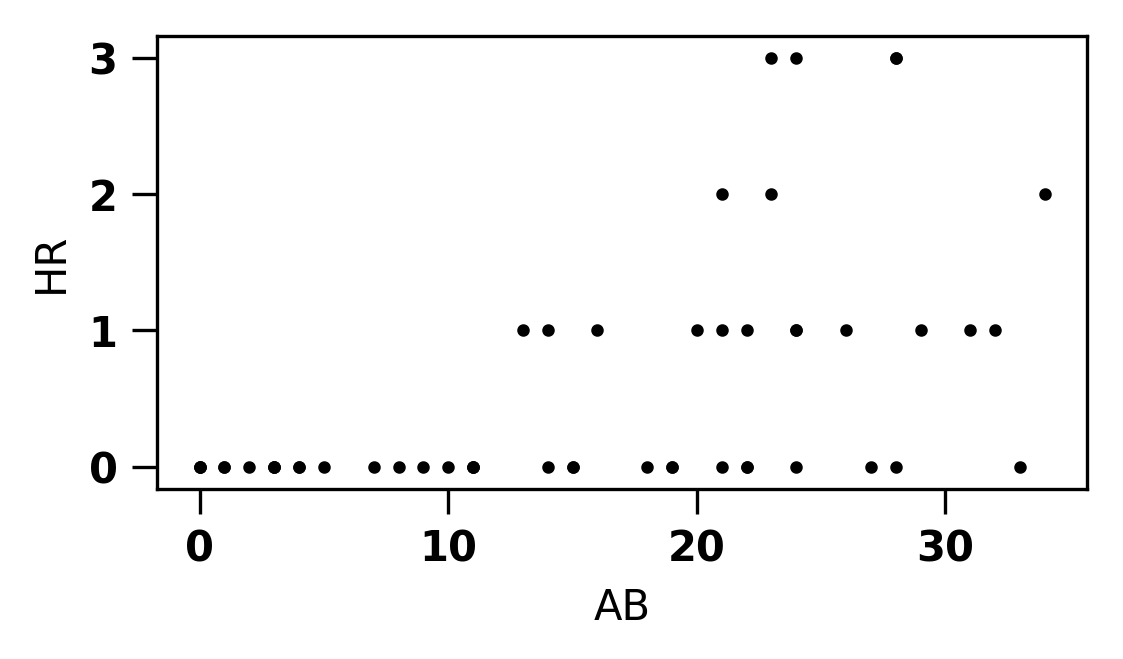

In [22]:

HR = np.zeros(len(PValsFull.keys()))
AB = np.zeros(len(PValsFull.keys()))



for indx,player in enumerate(np.array(PValsFull.keys())):
    HR[indx] = PValsFull[player]['HR']
    AB[indx] = PValsFull[player]['AB']



print PValsFull['Todd Frazier']

plt.figure(figsize=(4,2))
plt.scatter(AB,HR,color='black',s=4.)
#plt.plot([0.,40.],[0.,20.],color='gray')
#plt.plot([0.,40.],[0.,40./3.],color='gray',linestyle='dashed')
#plt.plot([0.,40.],[0.,40./4.],color='gray',linestyle='dotted')



plt.xlabel('AB')
plt.ylabel('HR')

{'AB': 27.0, '2B': 2.0, 'HR': 0.0, 'R': 3.0, 'SO': 7.0, 'RBI': 2.0, 'SB': 0.0, '1B': 3.0, '3B': 0.0}


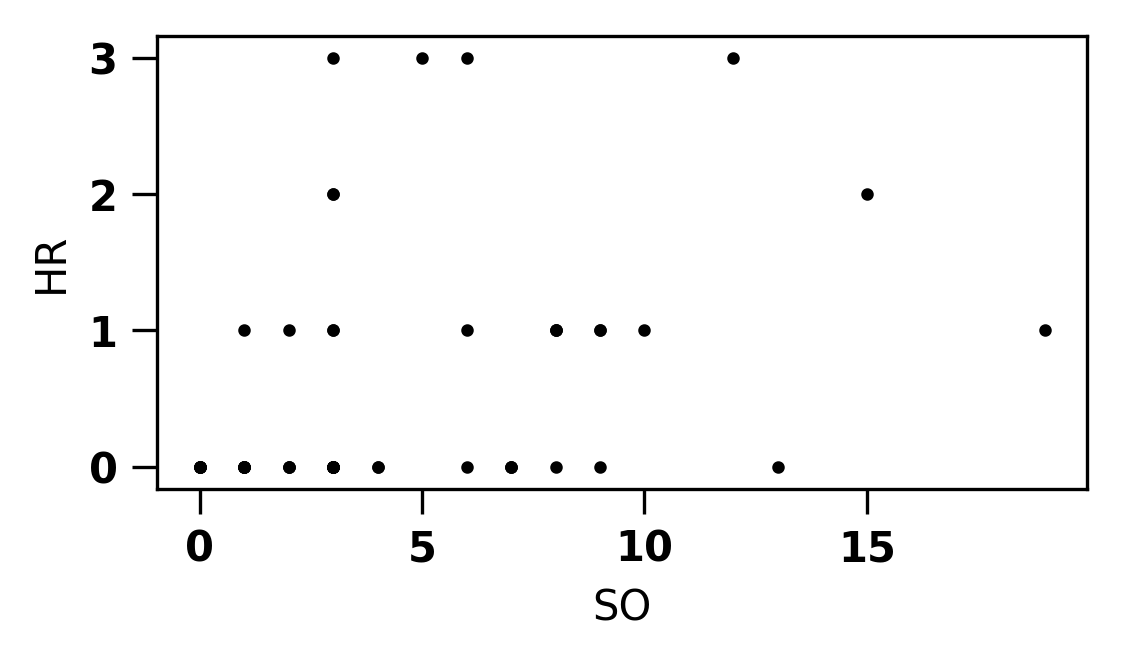

In [23]:

SO = np.zeros(len(PValsFull.keys()))
HR = np.zeros(len(PValsFull.keys()))



for indx,player in enumerate(np.array(PValsFull.keys())):
    SO[indx] = PValsFull[player]['SO']
    HR[indx] = PValsFull[player]['HR']



print PValsFull['Todd Frazier']

plt.figure(figsize=(4,2))
plt.scatter(SO,HR,color='black',s=4.)
#plt.plot([0.,40.],[0.,20.],color='gray')
#plt.plot([0.,40.],[0.,40./3.],color='gray',linestyle='dashed')
#plt.plot([0.,40.],[0.,40./4.],color='gray',linestyle='dotted')



plt.xlabel('SO')
plt.ylabel('HR')

In [77]:

def define_rater(PValsFull):

    thits = np.array([PValsFull[x]['1B'] for x in PValsFull.keys()]) +\
            np.array([PValsFull[x]['2B'] for x in PValsFull.keys()]) +\
            np.array([PValsFull[x]['3B'] for x in PValsFull.keys()]) +\
            np.array([PValsFull[x]['HR'] for x in PValsFull.keys()])


    AVG = {}
    AVG['RBI'] = np.mean(np.array([PValsFull[x]['RBI'] for x in PValsFull.keys()]))
    AVG['R'] = np.mean(np.array([PValsFull[x]['R'] for x in PValsFull.keys()]))
    AVG['SB'] = np.mean(np.array([PValsFull[x]['SB'] for x in PValsFull.keys()]))
    AVG['HR'] = np.mean(np.array([PValsFull[x]['HR'] for x in PValsFull.keys()]))
    AVG['AVG'] = np.mean(thits/np.array([PValsFull[x]['AB'] for x in PValsFull.keys()]))

    MED = {}
    MED['RBI'] = np.median(np.array([PValsFull[x]['RBI'] for x in PValsFull.keys()]))
    MED['R'] = np.median(np.array([PValsFull[x]['R'] for x in PValsFull.keys()]))
    MED['SB'] = np.median(np.array([PValsFull[x]['SB'] for x in PValsFull.keys()]))
    MED['HR'] = np.median(np.array([PValsFull[x]['HR'] for x in PValsFull.keys()]))
    MED['AVG'] = np.median(thits/np.array([PValsFull[x]['AB'] for x in PValsFull.keys()]))


    STD = {}
    STD['RBI'] = np.std(np.array([PValsFull[x]['RBI'] for x in PValsFull.keys()]))
    STD['R'] = np.std(np.array([PValsFull[x]['R'] for x in PValsFull.keys()]))
    STD['SB'] = np.std(np.array([PValsFull[x]['SB'] for x in PValsFull.keys()]))
    STD['HR'] = np.std(np.array([PValsFull[x]['HR'] for x in PValsFull.keys()]))
    STD['AVG'] = np.std(thits/np.array([PValsFull[x]['AB'] for x in PValsFull.keys()]))

    return AVG,MED,STD


AVG,MED,STD = define_rater(PValsFull)
AVG16,MED16,STD16 = define_rater(PValsFull16)
AVG15,MED15,STD15 = define_rater(PValsFull15)




In [107]:
print [Outlay15[x]['Tommy Pham'] for x in ['HR','RBI','R','SB','AVG']]

[-0.61165290141645623, -1.1256906192026457, -0.96502860322545114, -0.10838073233629693, array([ 14.10225154])]


In [79]:
print('{0:>4s}{1:>8s}{2:>8s}{3:>8s}'.format('','AVG','MED','STD'))
print('---------------------------')


for key in AVG.keys():
    print('{0:4s}{1:8.3f}{2:8.3f}{3:8.3f}'.format(key,AVG[key],MED[key],STD[key]))
print('---------------------------')


for key in AVG.keys():
    print('{0:4s}{1:8.3f}{2:8.3f}{3:8.3f}'.format(key,AVG16[key],MED16[key],STD16[key]))
    
print('---------------------------')


for key in AVG.keys():
    print('{0:4s}{1:8.3f}{2:8.3f}{3:8.3f}'.format(key,AVG15[key],MED15[key],STD15[key]))

         AVG     MED     STD
---------------------------
HR    16.318  14.000  10.274
SB     6.671   4.000   8.482
R     58.512  56.000  23.998
RBI   56.179  54.500  25.681
AVG    0.261   0.261   0.030
---------------------------
HR    14.867  13.000  10.972
SB     6.573   3.000   9.273
R     55.480  56.500  28.416
RBI   53.070  51.000  30.079
AVG    0.261   0.263   0.032
---------------------------
HR    13.251  11.000   9.809
SB     7.186   3.000   9.227
R     53.867  53.000  25.906
RBI   51.027  48.000  26.650
AVG    0.260   0.263   0.034


In [108]:


def compute_outlier(PDict_in,AVG_in,MED_in,STD_in):

    Outlay_in = {}
    Outlay_in['HR'] = {}
    Outlay_in['R'] = {}
    Outlay_in['RBI'] = {}
    Outlay_in['AVG'] = {}
    Outlay_in['SB'] = {}

    Outlay_in['Total'] = {}
    Outlay_in['TotalHSB'] = {}
    Outlay_in['TotalHAV'] = {}


    gdict = MED_in


    for indx,player in enumerate(PDict_in.keys()):
        
        if player=='Andrew Benintendi': print 'Found em'

        Outlay_in['HR'][player] = (PDict_in[player]['HR'] - gdict['HR'])/STD_in['HR']
        Outlay_in['R'][player] = (PDict_in[player]['R'] - gdict['R'])/STD_in['R']
        Outlay_in['RBI'][player] = (PDict_in[player]['RBI'] - gdict['RBI'])/STD_in['RBI']
        Outlay_in['SB'][player] = (PDict_in[player]['SB'] - gdict['SB'])/STD_in['SB']
        
        Outlay_in['AVG'][player] = 0.#(((thits[indx]/PDict_in[player]['AB']) - gdict['AVG'])/STD_in['AVG'])
        Outlay_in['Total'][player] = np.sum([Outlay_in['HR'][player],Outlay_in['R'][player],Outlay_in['RBI'][player], \
                                  Outlay_in['SB'][player],Outlay_in['AVG'][player]])
        Outlay_in['TotalHSB'][player] = np.sum([Outlay_in['HR'][player],Outlay_in['R'][player],Outlay_in['RBI'][player], \
                                  0.5*Outlay_in['SB'][player],Outlay_in['AVG'][player]])
        Outlay_in['TotalHAV'][player] = np.sum([Outlay_in['HR'][player],Outlay_in['R'][player],Outlay_in['RBI'][player], \
                                  Outlay_in['SB'][player],0.5*Outlay_in['AVG'][player]])

        
    return Outlay_in



Outlay = compute_outlier(PValsFull,AVG,MED,STD)
Outlay16 = compute_outlier(PValsFull16,AVG16,MED16,STD16)
Outlay15 = compute_outlier(PValsFull15,AVG15,MED15,STD15)



Found em
Found em


In [109]:
print Outlay['Total']['Mike Trout']
print Outlay16['Total']['Mike Trout']
print Outlay15['Total']['Mike Trout']

print Outlay['Total']['Tommy Pham']
print Outlay16['Total']['Andrew Benintendi']
print Outlay15['Total']['Tommy Pham']

6.15312949502
8.33937775318
7.46993558324
5.69739889861
-3.87365103671
-2.81075285618


In [114]:
print('{0:^6};{1:^20s};{2:^8s};{3:^8s};{4:^8s};{5:^8s};{6:^8s};{7:^8s}'.format(\
            'Rank','Player','Total','0.5SB','0.5AVG','Total16','Total15','Roll'))
print('--------------------------------------------------------------')


RollAvg = {}
for indx,player in enumerate(np.array(Outlay['Total'].keys())):
    
    
    if (player in Outlay16['Total'].keys()) & (player in Outlay15['Total'].keys()):

        RollAvg[player] = np.median([Outlay['Total'][player],Outlay16['Total'][player],Outlay15['Total'][player]])

    if (player in Outlay16['Total'].keys()) & (player not in Outlay15['Total'].keys()):

        RollAvg[player] = 0.8*np.median([Outlay['Total'][player],Outlay16['Total'][player]])

    if (player not in Outlay16['Total'].keys()) & (player in Outlay15['Total'].keys()):

        RollAvg[player] = 0.8*np.median([Outlay['Total'][player],Outlay15['Total'][player]])

    if (player not in Outlay16['Total'].keys()) & (player not in Outlay15['Total'].keys()):

        RollAvg[player] = 0.6*Outlay['Total'][player]







desc = (-1.*np.array(Outlay['Total'].values())).argsort()

#print(np.array(Outlay['Total'].keys())[desc])



for indx,player in enumerate(np.array(Outlay['Total'].keys())[desc]):
    
    if Outlay['Total'][player] > 4.0:
        
        if (player in Outlay16['Total'].keys()) & (player in Outlay15['Total'].keys()):
            print('{0:^6d};{1:20s};{2:^8.2f};{3:^8.2f};{4:^8.2f};{5:^8.2f};{6:^8.2f};{7:^8.2f}'.format(\
                    indx,player,Outlay['Total'][player],\
                           Outlay['TotalHSB'][player],\
                           Outlay['TotalHAV'][player],\
                           Outlay16['Total'][player],\
                           Outlay15['Total'][player],\
                           RollAvg[player]))

        elif (player in Outlay16['Total'].keys()) & (player not in Outlay15['Total'].keys()):
            print('{0:^6d};{1:20s};{2:^8.2f};{3:^8.2f};{4:^8.2f};{5:^8.2f};{6:^8s};{7:^8.2f}'.format(\
                    indx,player,Outlay['Total'][player],\
                           Outlay['TotalHSB'][player],\
                           Outlay['TotalHAV'][player],\
                           Outlay16['Total'][player],\
                           '',\
                           RollAvg[player]))
            
        elif (player not in Outlay16['Total'].keys()) & (player in Outlay15['Total'].keys()):
            print('{0:^6d};{1:20s};{2:^8.2f};{3:^8.2f};{4:^8.2f};{5:^8s};{6:^8.2f};{7:^8.2f}'.format(\
                    indx,player,Outlay['Total'][player],\
                           Outlay['TotalHSB'][player],\
                           Outlay['TotalHAV'][player],\
                           '',\
                           Outlay15['Total'][player],\
                           RollAvg[player]))
            
        else:
            print('{0:^6d};{1:20s};{2:^8.2f};{3:^8.2f};{4:^8.2f};;;{5:^8.2f}'.format(\
                indx,player,Outlay['Total'][player],\
                       Outlay['TotalHSB'][player],\
                       Outlay['TotalHAV'][player],\
                           RollAvg[player]))


 Rank ;       Player       ; Total  ; 0.5SB  ; 0.5AVG ;Total16 ;Total15 ;  Roll  
--------------------------------------------------------------
  0   ;Giancarlo Stanton   ;  9.95  ; 10.07  ;  9.95  ;  1.70  ;  2.22  ;  2.22  
  1   ;Aaron Judge         ;  9.61  ;  9.31  ;  9.61  ; -4.14  ;        ;  2.18  
  2   ;Paul Goldschmidt    ;  8.88  ;  8.06  ;  8.88  ;  7.33  ;  8.45  ;  8.45  
  3   ;Charlie Blackmon    ;  8.72  ;  8.13  ;  8.72  ;  5.92  ;  6.87  ;  6.87  
  4   ;Jose Altuve         ;  7.64  ;  5.99  ;  7.64  ;  7.22  ;  6.15  ;  7.22  
  5   ;Mookie Betts        ;  7.29  ;  6.00  ;  7.29  ;  8.49  ;  5.26  ;  7.29  
  6   ;Justin Upton        ;  7.18  ;  6.59  ;  7.18  ;  4.35  ;  5.74  ;  5.74  
  7   ;Dee Gordon          ;  7.01  ;  3.71  ;  7.01  ;  0.25  ;  6.52  ;  6.52  
  8   ;Brian Dozier        ;  6.94  ;  6.24  ;  6.94  ;  7.53  ;  5.65  ;  6.94  
  9   ;Nolan Arenado       ;  6.89  ;  6.95  ;  6.89  ;  7.26  ;  7.83  ;  7.26  
  10  ;Khris Davis         ;  6.44 

I'd love to go off the wall, but there just aren't that many realistic options. In fact, I squeezed pretty hard to get down to two guys on my team: Dee Gordon and Joey Votto. In the end, though, it came down to two guys for me: Giancarlo Stanton and Paul Goldschmidt. On the basis of consistency, I choose Goldy.

In [15]:
#
# for the top candidates, make a curve.
#'

itable = [u'Date', u'Team', u'Opp', u'BO', u'Pos', u'PA', u'H',\
          u'2B', u'3B', u'HR', u'R', u'RBI', u'SB', u'CS',\
          u'BB%', u'K%', u'ISO', u'BABIP', u'AVG', u'OBP', u'SLG', u'wOBA', u'wRC+']
#             0         1        2    3     4      5     6  \
#            7      8   9       10    11      12     13  \
#            14    15    16    17          18       19      20     21      22




plist = ['Paul Goldschmidt','Charlie Blackmon','Jose Altuve','Giancarlo Stanton']


#for player in HDict.keys():

def obtain_players(plist):
    
    # set up dictionary
    PVals = {}

    pnum = 0

    for player in plist:
        PVals[player] = {}
        #print player,

        get_url = 'http://www.fangraphs.com/statsd.aspx?playerid='+str(HDict[player].strip())
        
        #print get_url

        r  = requests.get(get_url)

        data = r.text

        soup = BeautifulSoup(data)

        tables = soup.findAll('table')

        birth_year = float(get_birth_year(tables))

        PVals[player]['bo'] = []
        PVals[player]['pos'] = []
        PVals[player]['h'] = []
        PVals[player]['ab'] = []
        PVals[player]['hr'] = []
        PVals[player]['rbi'] = []
        PVals[player]['r'] = []
        PVals[player]['sb'] = []



        for indx,table in enumerate(tables):

            #print indx,[th.get_text() for th in table.find("tr").find_all("th")]

            if [th.get_text() for th in table.find("tr").find_all("th")] == itable:

                #print get_url
                if (pnum % 1) == 0:
                    print pnum,player

                pnum += 1

                #print [th.get_text() for th in table.find("tr").find_all("th")]

                #print table.find_all("tr", class_="grid_multi")

                for row in table.find_all("tr")[1:]:
                    

                    if (row in table.find_all("tr", class_="grid_postseason")) |\
                        (row in table.find_all("tr", class_="grid_multi")):
                            #print 'Multi and/or Postseason:',sav[0]
                            continue


                    sav = [td.get_text() for td in row.find_all("td")]
                    
                    #print sav
                    
                    #print sav
                
                    
                    if ('Date' not in sav[0]) & ('Total' not in sav[0]) :
                        PVals[player]['bo'].append(float(sav[3]))
                        PVals[player]['h'].append(float(sav[6]))
                        PVals[player]['ab'].append(float(sav[5]))
                        PVals[player]['hr'].append(float(sav[9]))
                        PVals[player]['rbi'].append(float(sav[11]))
                        PVals[player]['r'].append(float(sav[10]))
                        PVals[player]['sb'].append(float(sav[12]))
                        
                        try:
                            if sav[4][1] == 'F': 
                                PVals[player]['pos'].append('OF')
                        
                            elif sav[4][1] == '-':
                                PVals[player]['pos'].append(sav[4][0:1])
                        
                            else:
                                PVals[player]['pos'].append(sav[4][0:2])
                                
                        except:
                            PVals[player]['pos'].append(sav[4][0:1])

                    #if (np.sum([(x.strip() in sav[1]) for x in projections])==0) & \
                    #(np.sum([(x in sav[1]) for x in minors])==0) & \
                    #(np.sum([(x in sav[0]) for x in agg])==0): 
                    #    try:
                    #        PVals[player]['bo'].append(float(sav[0])-birth_year)
                    #        PVals[player]['pos'].append(float(sav[14])/float(sav[4]))
                    #        PVals[player]['bbr'].append(float(sav[12])/float(sav[4]))

                    #    except:
                    #        # this is janky way to skip postseason. please fix this
                    #        #print 'Skipped for postseason',sav[0],sav[1]
                    #        pass

    return PVals


PVals = obtain_players(plist)




0 Paul Goldschmidt
1 Charlie Blackmon
2 Jose Altuve
3 Giancarlo Stanton


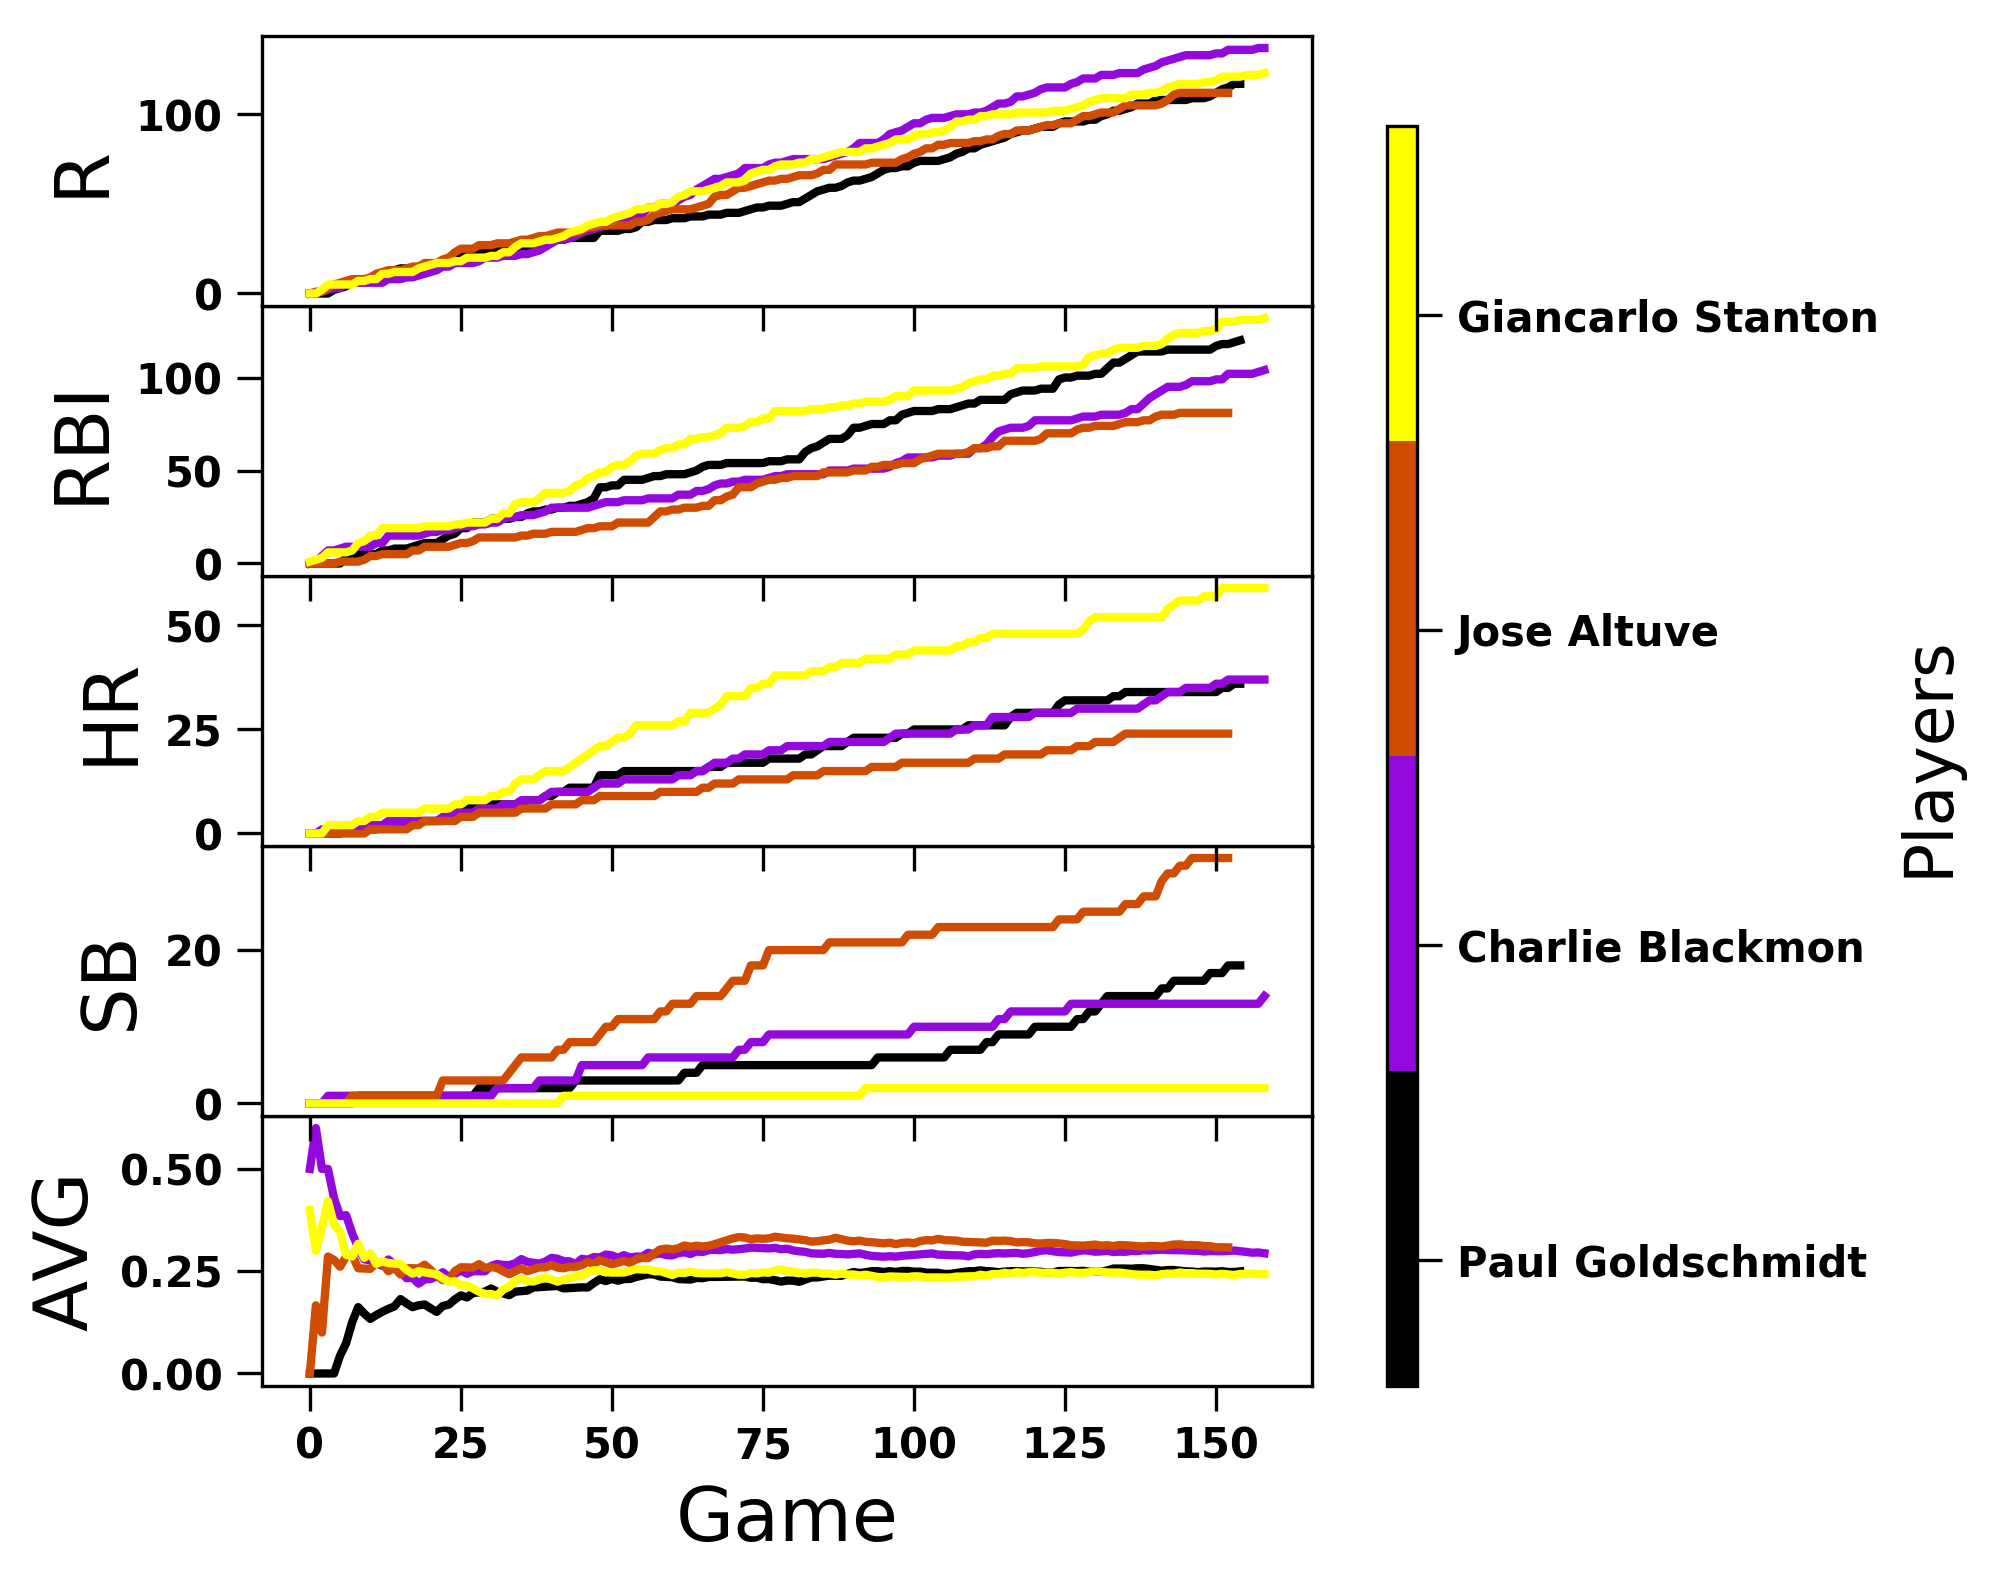

In [16]:
plot_plist(plist,PVals)

In [17]:
# draw 6 random games from the sample and see how RBIs go

nsamp = 10000

MCarlo = {}
MCarlo['HR'] = {}
MCarlo['R'] = {}
MCarlo['RBI'] = {}
MCarlo['SB'] = {}




for player in plist:
    
     
    
    start = np.random.randint(0,len(PVals[player]['hr'])-6,nsamp)
    
    MCarlo['HR'][player] = np.mean(np.array([np.sum(PVals[player]['hr'][startx:startx+6]) for startx in start]))
    MCarlo['R'][player] = np.mean(np.array([np.sum(PVals[player]['r'][startx:startx+6]) for startx in start]))
    MCarlo['RBI'][player] = np.mean(np.array([np.sum(PVals[player]['rbi'][startx:startx+6]) for startx in start]))
    MCarlo['SB'][player] = np.mean(np.array([np.sum(PVals[player]['sb'][startx:startx+6]) for startx in start]))



    




In [18]:
print MCarlo['HR']
print MCarlo['R']
print MCarlo['RBI']
print MCarlo['SB']

{'Paul Goldschmidt': 1.3965000000000001, 'Jose Altuve': 0.99080000000000001, 'Giancarlo Stanton': 2.29, 'Charlie Blackmon': 1.4301999999999999}
{'Paul Goldschmidt': 4.5193000000000003, 'Jose Altuve': 4.4964000000000004, 'Giancarlo Stanton': 4.6940999999999997, 'Charlie Blackmon': 5.3192000000000004}
{'Paul Goldschmidt': 4.7122999999999999, 'Jose Altuve': 3.2951999999999999, 'Giancarlo Stanton': 5.0345000000000004, 'Charlie Blackmon': 3.8799000000000001}
{'Paul Goldschmidt': 0.69350000000000001, 'Jose Altuve': 1.2827, 'Giancarlo Stanton': 0.078200000000000006, 'Charlie Blackmon': 0.48980000000000001}
